In [5]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [6]:
import pandas as pd
cap = pd.read_csv("/Users/houzhuo/Downloads/capdata3.csv")
robot    = pd.read_csv("/Users/houzhuo/Downloads/robot.csv")
full = pd.concat([cap,robot],axis=1)
full.head()
#cap_head = pd.concat(cap_headx,cap_heady,cap_headz)
dataset = pd.concat( [  full['Head'],full['77'] ] , axis=1 )
dataset.head()
type(dataset)

pandas.core.frame.DataFrame

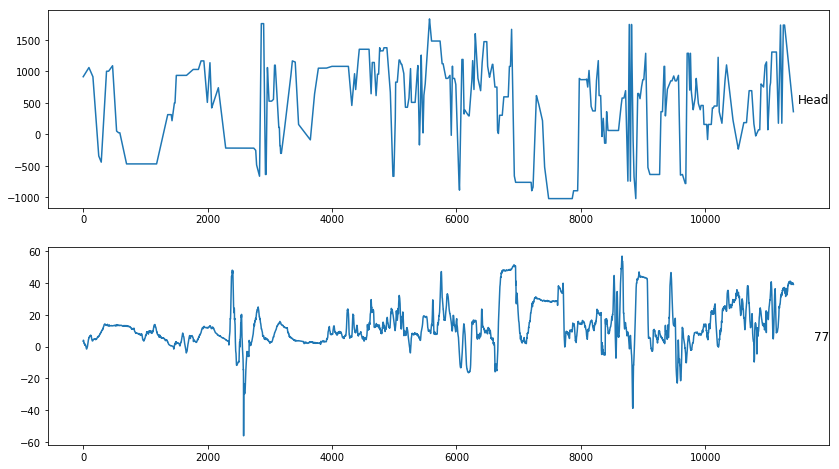

In [9]:
import matplotlib.pyplot as plt
values = dataset.values
# specify columns to plot
groups = [0, 1]
i=1
plt.figure(figsize=(14,8))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [10]:
import numpy as np
values = dataset.values
values = dataset.astype(np.float32)
#values -= np.mean(values, axis = 0)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
#reframed = series_to_supervised(scaled, 1, 1)
time_step=1
n_features=1
reframed = series_to_supervised(scaled, time_step, 1)

print(reframed.shape)
reframed.head()

(11419, 4)


,var1(t-1),var2(t-1),var1(t),var2(t)
1,0.678209,0.526011,0.678764,0.529421
2,0.678764,0.529421,0.679319,0.531716
3,0.679319,0.531716,0.679874,0.531912
4,0.679874,0.531912,0.680429,0.531621
5,0.680429,0.531621,0.680985,0.531468


In [13]:
values = reframed.values
train = values[:8000,:]
val = values[8000:10000,:]
test = values[10000:,:]

encoder_input_data = train[:,1:2]
decoder_input_data =  train[:,:1]
decoder_target_data = train[:,2:3]

print(decoder_input_data.shape,decoder_target_data.shape)

(8000, 1) (8000, 1)


In [22]:
from __future__ import print_function

batch_size = 64  # Batch size for training.
epochs = 25  # Number of epochs to train for.
latent_dim = 128  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'cmn-eng/cmn.txt'


# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, time_step))#shape是（none，encoder的词袋长度），还是说none为主体，后边fit时候可替换？
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,time_step))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(time_step, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [23]:
encoder_input_data = encoder_input_data.reshape(8000,time_step,n_features)
decoder_input_data = decoder_input_data.reshape(8000,time_step,n_features)
decoder_target_data =decoder_target_data.reshape(8000,time_step,n_features)

In [26]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,#fit的时候采用的是前面的时序序列
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 6400 samples, validate on 1600 samples
Epoch 1/25
 960/6400 [===>..........................] - ETA: 15s - loss: 0.0000e+00

InvalidArgumentError: Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
	 [[Node: loss_4/dense_2_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](loss_4/dense_2_loss/Reshape_1, loss_4/dense_2_loss/Cast)]]

Caused by op 'loss_4/dense_2_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits', defined at:
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-e2c8df8b0b79>", line 6, in <module>
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 830, in compile
    sample_weight, mask)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 429, in weighted
    score_array = fn(y_true, y_pred)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/keras/losses.py", line 73, in sparse_categorical_crossentropy
    return K.sparse_categorical_crossentropy(y_true, y_pred)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3041, in sparse_categorical_crossentropy
    logits=logits)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 2052, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 7451, in sparse_softmax_cross_entropy_with_logits
    labels=labels, name=name)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/Users/houzhuo/Documents/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
	 [[Node: loss_4/dense_2_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](loss_4/dense_2_loss/Reshape_1, loss_4/dense_2_loss/Cast)]]
